# Experiment with U-net segmentation

Import packages

In [1]:
import os
import random

from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import load_img, img_to_array

2025-06-11 15:34:45.527972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-11 15:34:45.546685: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-11 15:34:45.546712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-11 15:34:45.557606: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-11 15:34:47.623221: W tensorflow/compiler/tf

In [2]:
import matplotlib.pyplot as plt

def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    
    return (ax1, ax2)

Define directories for dataset

In [3]:
image_dir = "../raw_data/segmentation/TIFF"
mask_dir = "../raw_data/segmentation/Mask"

IMG_SIZE = (224, 224)

In [4]:
VALID_IMAGE_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')

def load_data(image_dir, mask_dir, image_size=IMG_SIZE):
    images, masks = [], []

    for filename in os.listdir(image_dir):
        if not filename.lower().endswith(VALID_IMAGE_EXTENSIONS):
            continue  # Skip non-image files

        img_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename)

        try:
            # Load image
            img = load_img(img_path, target_size=image_size)
            img = img_to_array(img) / 255.0

            # Load mask or create blank
            if os.path.exists(mask_path):
                mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")
                mask = img_to_array(mask) / 255.0
                mask = np.round(mask)
            else:
                mask = np.zeros((image_size[0], image_size[1], 1), dtype=np.float32)

            images.append(img)
            masks.append(mask)

        except Exception as e:
            print(f"Skipping {filename}: {e}")

    return np.array(images), np.array(masks)

In [5]:
X, y = load_data(image_dir, mask_dir)
X.shape

(511, 224, 224, 3)

Visualize an image

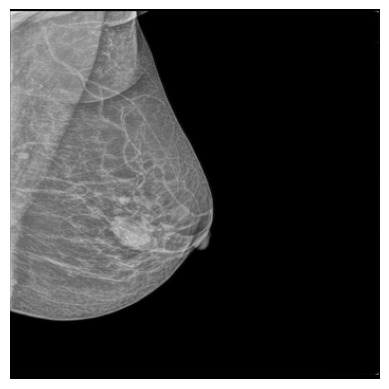

In [6]:
sample_image_path = image_dir + "/IMG001.png"
sample_image = Image.open(sample_image_path).resize((350, 350))
plt.imshow(sample_image)
plt.axis('off')  # Turn off the axes for a cleaner visualization
plt.show()

## Setup model: U-net

In [7]:
from tensorflow.keras import layers, Model

def unet_model(input_size=(IMG_SIZE[0], IMG_SIZE[1], 3), dropout_rate = 0.2):
    inputs = layers.Input(input_size)
    
    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    d1 = layers.Dropout(dropout_rate)(c1)
    p1 = layers.MaxPooling2D((2, 2))(d1)
    
    # Encoder
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    d2 = layers.Dropout(dropout_rate)(c2)
    p2 = layers.MaxPooling2D((2, 2))(d2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    d3 = layers.Dropout(dropout_rate)(c3)
    p3 = layers.MaxPooling2D((2, 2))(d3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    d4 = layers.Dropout(dropout_rate)(c4)
    p4 = layers.MaxPooling2D((2, 2))(d4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)
    d5 = layers.Dropout(dropout_rate)(c5)
    
    # Decoder
    u6 = layers.UpSampling2D()(d5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D()(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.UpSampling2D()(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)
    
    u9 = layers.UpSampling2D()(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

Loss

In [8]:
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [9]:
from tensorflow.keras.losses import BinaryCrossentropy

def bce_dice_loss(y_true, y_pred):
    bce = BinaryCrossentropy()(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

Compile

In [10]:
from keras import optimizers

def build_model():
    model = unet_model()
    model.compile(loss=bce_dice_loss, 
                  optimizer = optimizers.Adam(learning_rate=1e-3), 
                  metrics = ["accuracy"])

    return model

In [11]:
build_model().summary()

2025-06-11 15:34:52.770341: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-11 15:34:52.799214: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-11 15:34:52.799279: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-11 15:34:52.801231: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-11 15:34:52.801299: I external/local_xla/xla/stream_executor

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 224, 224,  │          0 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 112, 112,  │          0 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 56, 56,    │          0 │ conv2d_5[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ dropout_2[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 28, 28,    │          0 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 14, 14,    │          0 │ dropout_3[0][0] 

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

model = build_model()

es = EarlyStopping(patience = 5, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    decay_rate = 0.95
    decay_step = 4
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / 2*decay_step))
    return lr

with tf.device("/GPU:0"):
    history = model.fit(X,y,
                        validation_split=0.2,
                        batch_size=32,
                        epochs=60,
                        callbacks=[es, LearningRateScheduler(lr_scheduler, verbose=1)],
                        verbose=1)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/60
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.7933 - loss: 7.0810

KeyboardInterrupt: 

In [ ]:
preds = model.predict(X)
preds_binary = (preds > 0.5).astype(np.uint8)

In [ ]:
for i in random.sample(range(1, len(X)), 20):
    plt.figure(figsize=(16, 4))  # Wider figure to fit 4 subplots

    plt.subplot(1, 4, 1)
    plt.imshow(X[i])
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(y[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(preds_binary[i].squeeze(), cmap='gray')
    plt.title("Prediction (binary)")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title("Prediction (raw)")
    plt.axis('off')
    

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_overlay(image, mask, alpha=0.4, mask_color='Reds'):
    """
    image: numpy array, shape (H, W, 3)
    mask: numpy array, shape (H, W) or (H, W, 1)
    alpha: transparency of the mask overlay
    mask_color: colormap for the mask (e.g., 'Reds', 'Greens', 'jet')
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.imshow(mask.squeeze(), cmap=mask_color, alpha=alpha)
    plt.axis('off')
    plt.title("Image with Mask Overlay")
    plt.show()
    
for i in random.sample(range(1, len(X)), 5):
    plt.figure(figsize=(12, 4))
    
    plot_overlay(X[i], y[i])                     # Ground truth
    plot_overlay(X[i], preds_binary[i])          # Binary prediction
    plot_overlay(X[i], preds[i], alpha=0.3)      # Soft prediction
    
    plt.tight_layout()
    plt.show()